# Importing the required libraries

In [16]:
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
from PIL import Image

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import torch
import torch.nn as nn
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from torchsummary import summary
from torchvision import models

import warnings
warnings.filterwarnings("ignore")

# Loading the data from dataset

In [17]:
train_dir = "./fruits-100/train"
test_dir = "./fruits-100/test"
valid_dir = "./fruits-100/val"

print("Path Directory: ", os.listdir("./fruits-100"))
print("Train Directory:", os.listdir(train_dir))
print("valid Direcory: ", os.listdir(valid_dir))
print("Test Directory: ", os.listdir(test_dir))

NUM_CLASSES = len(next(os.walk(train_dir))[1])
print("Number of classes: ", NUM_CLASSES)

CLASS_NAMES = next(os.walk(train_dir))[1]

Path Directory:  ['classname.txt', 'test', 'test.csv', 'train', 'train.cache', 'train.csv', 'val', 'val.cache', 'val.csv']
Train Directory: ['abiu', 'acai', 'acerola', 'ackee', 'ambarella', 'apple', 'apricot', 'avocado', 'banana', 'barbadine', 'barberry', 'betel_nut', 'bitter_gourd', 'black_berry', 'black_mullberry', 'brazil_nut', 'camu_camu', 'cashew', 'cempedak', 'chenet', 'cherimoya', 'chico', 'chokeberry', 'classname.txt', 'cluster_fig', 'coconut', 'corn_kernel', 'cranberry', 'cupuacu', 'custard_apple', 'damson', 'dewberry', 'dragonfruit', 'durian', 'eggplant', 'elderberry', 'emblic', 'feijoa', 'fig', 'finger_lime', 'gooseberry', 'goumi', 'grape', 'grapefruit', 'greengage', 'grenadilla', 'guava', 'hard_kiwi', 'hawthorn', 'hog_plum', 'horned_melon', 'indian_strawberry', 'jaboticaba', 'jackfruit', 'jalapeno', 'jamaica_cherry', 'jambul', 'jocote', 'jujube', 'kaffir_lime', 'kumquat', 'lablab', 'langsat', 'longan', 'mabolo', 'malay_apple', 'mandarine', 'mango', 'mangosteen', 'medlar', '

In [18]:
print("Training banana data:",len(os.listdir(train_dir+'/'+'banana')))
print("Testing banana data:",len(os.listdir(test_dir+'/'+'79')))
print("Validation banana data:",len(os.listdir(valid_dir+'/'+'banana')))

Training banana data: 400
Testing banana data: 50
Validation banana data: 50


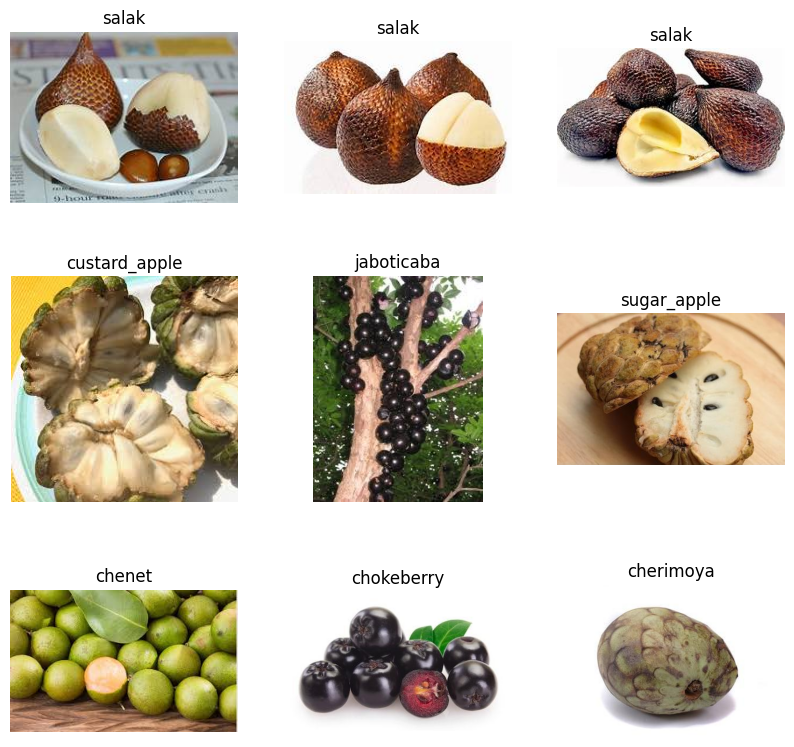

In [19]:
# Function to show random images from training dataset

def show_random_images(data_dir, num_images):
    class_names = os.listdir(data_dir)
    num_rows = int(num_images ** 0.5)
    num_cols = int(num_images ** 0.5)
    fig, axarr = plt.subplots(num_rows, num_cols, figsize=(10,10))
    for i in range(num_rows):
        for j in range(num_cols):
            class_num = random.randint(0, len(class_names)-1)
            img_name = random.choice(os.listdir(os.path.join(data_dir, class_names[class_num])))
            img_path = os.path.join(data_dir, class_names[class_num], img_name)
            img = mpimg.imread(img_path)
            axarr[i, j].imshow(img, cmap = 'gray')
            axarr[i, j].set_title(class_names[class_num])
            axarr[i, j].axis('off')
            
    plt.show()

show_random_images(train_dir, 9)

# Image Preprocessing

In [20]:
image_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        
    ]),
    
    'valid': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
}

In [21]:
data = {
    'train': datasets.ImageFolder(root=train_dir, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_dir, transform=image_transforms['valid'])
}

print("Training data: ", len(data['train']))
print("Validation data: ", len(data['valid']))

Training data:  40000
Validation data:  5000


In [22]:
BATCH_SIZE = 32

train_loader = DataLoader(data['train'], batch_size = BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(data['valid'], batch_size = BATCH_SIZE, shuffle=True)

# Loading pretrainded model

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [24]:
# Loading Pretrained Weights of Resnet50
model = models.resnet50(pretrained = True).to(device)
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

# Building and Training Model

In [25]:
# Freeze all layers except the last one
for param in model.parameters():
    param.requires_grad = False

num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(64, NUM_CLASSES)
)

# Transfer the model to device
model = model.to(device)

### Define loss function and optimizer

In [26]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

### Training loop

In [27]:
num_epochs = 5
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    train_loss = 0
    valid_loss = 0

    # Training loop
    model.train()
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)
    
        # Validation loop
    model.eval()
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        valid_loss += loss.item() * images.size(0)
        valid_loss /= len(valid_loader.dataset)
        valid_losses.append(valid_loss)
    
    # Print training and validation loss
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}')


Epoch [1/5], Train Loss: 0.0037, Valid Loss: 0.0073
Epoch [2/5], Train Loss: 0.0037, Valid Loss: 0.0072
Epoch [3/5], Train Loss: 0.0036, Valid Loss: 0.0068
Epoch [4/5], Train Loss: 0.0033, Valid Loss: 0.0064
Epoch [5/5], Train Loss: 0.0031, Valid Loss: 0.0061


# Test the model on test dataset

In [28]:
test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

test_data = datasets.ImageFolder(test_dir, transform=test_transforms)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)


model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    y_pred = []
    y_true = []
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())
    print('Test Accuracy of the model on the test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the test images: 2.1 %


### Plot confusion matrix

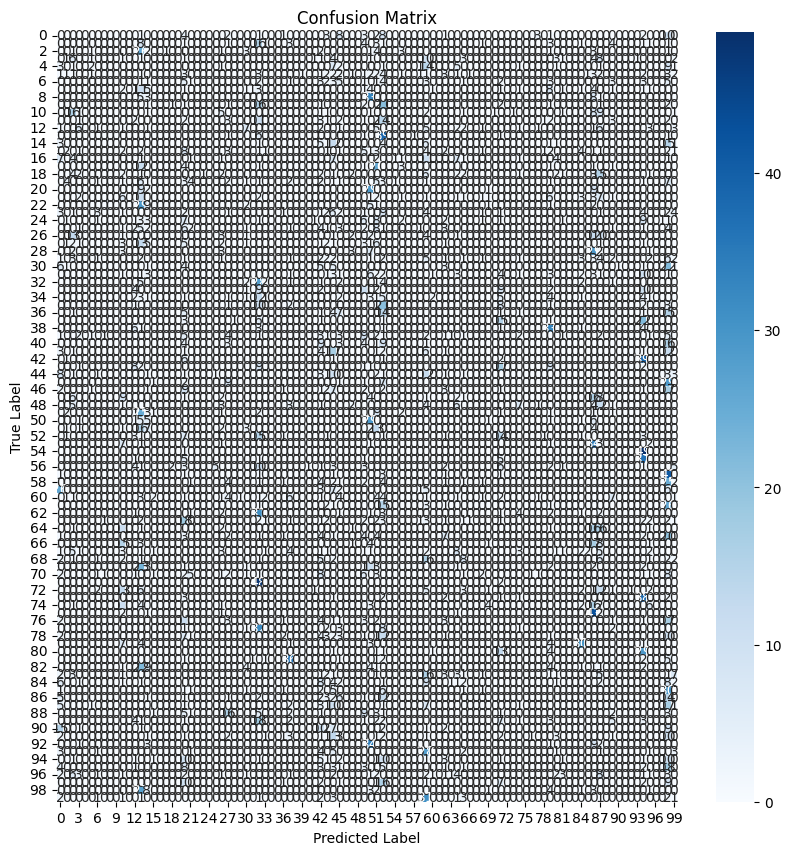

                   precision    recall  f1-score   support

             abiu       0.00      0.00      0.00        50
             acai       0.00      0.00      0.00        50
          acerola       0.01      0.02      0.01        50
            ackee       0.00      0.00      0.00        50
        ambarella       0.00      0.00      0.00        50
            apple       0.12      0.02      0.03        50
          apricot       0.00      0.00      0.00        50
          avocado       0.00      0.00      0.00        50
           banana       0.00      0.00      0.00        50
        barbadine       0.00      0.00      0.00        50
         barberry       0.00      0.00      0.00        50
        betel_nut       0.00      0.00      0.00        50
     bitter_gourd       0.00      0.00      0.00        50
      black_berry       0.00      0.00      0.00        50
  black_mullberry       0.00      0.00      0.00        50
       brazil_nut       0.00      0.00      0.00       

In [29]:
# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))